In [62]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
import pickle 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, IncrementalPCA

In [4]:
aita_2 = pd.read_csv('data/aita_save2.csv')
aita_2.dropna(subset=['body_clean', 'title_clean'], inplace=True)

aita = aita_2[['body_polarity','body_subjectivity','is_asshole']]
aita['title_body_combo'] =  aita_2['title_clean'] + aita_2['body_clean']
aita.dropna(inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
aita

,body_polarity,body_subjectivity,is_asshole,title_body_combo
0,-0.156818,0.656818,1,I write an explanation in til and come off a...
1,0.034848,0.449242,1,throw my parent donut awaymy parent be diabe...
2,0.000000,0.000000,0,I tell a goth girl she look like a clownI be four
3,0.000000,0.000000,1,argument I have with another redditor in rhi...
4,0.040104,0.369792,1,have a disagreement about le miserable with ...
...,...,...,...,...
97536,0.016111,0.385278,0,for tell my sister she be be a spoiled bratm...
97537,0.068461,0.474614,0,for tell my husband to f off after he relent...
97538,-0.076333,0.493467,0,for attempt to keep my student out of adult ...
97539,0.067130,0.426132,0,if I leave my brother fate up to the statea ...


## 1 - Save features X and labels y, train test split

In [6]:
X = aita.drop('is_asshole', axis=1)
y = aita['is_asshole']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.01, random_state=11)

In [7]:
X_train.shape, X_test.shape

((96480, 3), (975, 3))

## 2 - Instantiate CountVectorizer 

In [28]:
stop = set(stopwords.words('english'))
vec = CountVectorizer(stop_words=stop, min_df=0.005, max_df=0.8, ngram_range=(1, 2))
cv = vec.fit(X_train['title_body_combo'])

In [29]:
len(vec.get_feature_names())

3850

#### Save fitted CountVectorizer to use later

In [11]:
# pickle.dump(cv, open('models/cv_fit_train.sav', 'wb'))

#### Load fitted CountVectorizer

In [6]:
# cv = pickle.load(open('models/cv_fit_train.sav', 'rb'))

### 2.a Transform train and test data into document-term-matrix with CountVectorizer

In [30]:
cv_train = cv.transform(X_train['title_body_combo'])
cv_test = cv.transform(X_test['title_body_combo'])

In [32]:
cv_cols = cv.get_feature_names()
dtm_train = pd.DataFrame(cv_train.toarray(), columns=cv_cols)
dtm_test = pd.DataFrame(cv_test.toarray(), columns=cv_cols)

In [40]:
train_word_count = dtm_train.sum(axis=0)
train_word_count.sort_values(ascending=False)[:10]

get       228922
go        198113
say       197408
tell      169258
would     165609
want      159291
like      139417
friend    132208
time      122214
know      108087
dtype: int64

In [36]:
test_word_count = dtm_test.sum(axis=0)
test_word_count.sort_values(ascending=False)[:10]

get       2354
say       1991
go        1967
tell      1704
want      1680
would     1608
like      1352
friend    1291
time      1262
know      1147
dtype: int64

In [37]:
# ((96480, 44051), (975, 44051))
dtm_train.shape, dtm_test.shape

((96480, 3850), (975, 3850))

### Save / Load Document Term Matrix to / from csv

In [25]:
# dtm_train.to_csv('data/dtm_train.csv', index=False)
# dtm_test.to_csv('data/dtm_test.csv', index=False)

# dtm_train = pd.read_csv('data/dtm_train.csv')
# dtm_test = pd.read_csv('data/dtm_test.csv')

## 3 - PCA

In [38]:
pca = IncrementalPCA(n_components=800, batch_size=850)
pca.fit(dtm_train)
print(pca.explained_variance_ratio_.sum())

0.8423388480400277


### Save / Load fitted PCA Model

In [41]:
pickle.dump(pca, open('models/pca.sav', 'wb'))
# pca = pickle.load(open('models/pca.sav', 'rb'))
# pca

### 3.a Scree plot, check number of components is appropriate

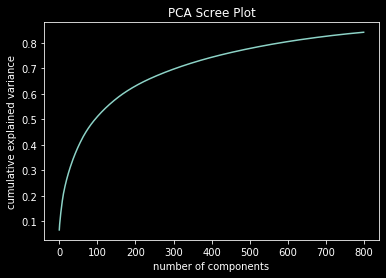

In [39]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('PCA Scree Plot')
# plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
evr = pca.explained_variance_ratio_
cvr = np.cumsum(pca.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
# display(pca_df.head(10))

### 3.b - Transform train/test Document-Term-matrix with PCA

In [43]:
dtm_train_pca = pca.transform(dtm_train)
dtm_test_pca = pca.transform(dtm_test)

Build DataFrame of PCA Components

In [44]:
col_names = ['PC_' + str(i) for i in range(1, pca.get_params()['n_components']+1)]
dtm_train_pca_df = pd.DataFrame(dtm_train_pca, columns=col_names)
dtm_test_pca_df = pd.DataFrame(dtm_test_pca, columns=col_names)

Combine PCA components and sentiment analysis scores into one DataFrame

In [45]:
X_train_post_dtm_pca = pd.concat([X_train[['body_polarity','body_subjectivity']].reset_index(drop=True), dtm_train_pca_df], axis=1)
X_test_post_dtm_pca = pd.concat([X_test[['body_polarity','body_subjectivity']].reset_index(drop=True),dtm_test_pca_df], axis=1)

In [46]:
X_train_post_dtm_pca.head()

,body_polarity,body_subjectivity,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,...,PC_791,PC_792,PC_793,PC_794,PC_795,PC_796,PC_797,PC_798,PC_799,PC_800
0,0.089698,0.382755,6.721062,3.945255,-3.471649,-2.540817,-1.755770,-1.530562,-4.131972,3.995945,...,0.090375,-0.634156,-0.356446,0.235280,0.338331,-0.506310,0.407767,-0.156681,0.328248,-0.305217
1,-0.140000,0.601585,5.761561,0.596863,-2.237171,-3.185759,-1.131884,-2.262600,-2.888938,0.091418,...,-0.521899,-0.763363,0.620522,0.318312,0.675178,0.760419,0.822378,-0.192563,0.465362,1.029007
2,0.034758,0.575265,1.966241,-1.712645,-0.909865,0.264539,0.921549,5.895036,1.228376,-1.104059,...,-0.016981,-0.175593,0.031395,0.089073,-0.180081,0.025352,0.025359,-0.034695,0.128525,0.134961
3,-0.009470,0.545676,-0.266427,0.267081,2.156305,-2.304990,-2.705240,-2.705795,-0.498179,0.245619,...,-0.440284,-0.017129,0.046089,-0.495012,-0.651864,0.408607,0.301299,0.130943,-0.954164,0.605056
4,0.196644,0.494792,2.398380,-0.615288,-0.211554,-3.215119,-1.241756,1.164878,4.107588,2.698780,...,-0.076834,0.109758,-0.102025,-0.278899,0.029033,-0.506665,0.143349,-0.365991,-0.151719,0.129302


In [47]:
print(X_train_post_dtm_pca.shape, y_train.shape)
print(X_test_post_dtm_pca.shape, y_test.shape)

(96480, 802) (96480,)
(975, 802) (975,)


# Models

## 1 - Random Forest Models

### 1.a Vanilla Random Forest, no tuning hyperparameters 

In [49]:
rfc = RandomForestClassifier()
rfc.fit(X_train_post_dtm_pca, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [53]:
cross_val_score(rfc, X_train_post_dtm_pca, y_train, cv=5, scoring='f1')

array([0.01932008, 0.01416853, 0.00824279, 0.01418704, 0.0134882 ])

In [54]:
print(f'Testing Accuracy = {rfc.score(X_test_post_dtm_pca, y_test)}')

Testing Accuracy = 0.7271794871794872


In [97]:
y_pred_train = rfc.predict(X_train_post_dtm_pca)
print(confusion_matrix(y_train,y_pred_train))
# print(classification_report(y_train,y_pred_train))
print(f'F1 Score = {f1_score(y_train,y_pred_train)}')
print(f'Accuracy Score = {accuracy_score(y_train,y_pred_train)}')

[[70299     0]
 [    0 26181]]
F1 Score = 1.0
Accuracy Score = 1.0


In [96]:
y_pred_test = rfc.predict(X_test_post_dtm_pca)
print(confusion_matrix(y_test,y_pred_test))
# print(classification_report(y_test,y_pred_test))
print(f'F1 Score = {f1_score(y_test,y_pred_test)}')
print(f'Accuracy Score = {accuracy_score(y_test,y_pred_test)}')

[[707   3]
 [263   2]]
F1 Score = 0.014814814814814815
Accuracy Score = 0.7271794871794872


### 1.b weighted random forest

In [61]:
rfc2 = RandomForestClassifier(class_weight="balanced")
rfc2.fit(X_train_post_dtm_pca, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [94]:
y_pred_train_2 = rfc2.predict(X_train_post_dtm_pca)
print(confusion_matrix(y_train,y_pred_train_2))
# print(classification_report(y_train,y_pred_train_2))
print(f'F1 Score = {f1_score(y_train,y_pred_train_2)}')
print(f'Accuracy Score = {accuracy_score(y_train,y_pred_train_2)}')

[[70299     0]
 [    0 26181]]
F1 Score = 1.0
Accuracy Score = 1.0


In [93]:
y_pred_test_2 = rfc2.predict(X_test_post_dtm_pca)
print(confusion_matrix(y_test,y_pred_test_2))
# print(classification_report(y_test,y_pred_test_2))
print(f'F1 Score = {f1_score(y_test,y_pred_test_2)}')
print(f'Accuracy Score = {accuracy_score(y_test,y_pred_test_2)}')

[[710   0]
 [264   1]]
F1 Score = 0.0075187969924812035
Accuracy Score = 0.7292307692307692


## 2 - Logistic Regression

In [68]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train_post_dtm_pca, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [98]:
y_pred_train_lr = lr.predict(X_train_post_dtm_pca)
print(confusion_matrix(y_train,y_pred_train_lr))
# print(classification_report(y_train,y_pred_train_lr))
print(f'F1 Score = {f1_score(y_train,y_pred_train_lr)}')
print(f'Accuracy Score = {accuracy_score(y_train,y_pred_train_lr)}')

[[41623 28676]
 [ 9777 16404]]
F1 Score = 0.460392079819256
Accuracy Score = 0.6014407131011609


In [99]:
y_pred_test_lr = lr.predict(X_test_post_dtm_pca)
print(confusion_matrix(y_test,y_pred_test_lr))
# print(classification_report(y_test,y_pred_test_lr))
print(f'F1 Score = {f1_score(y_test,y_pred_test_lr)}')
print(f'Accuracy Score = {accuracy_score(y_test,y_pred_test_lr)}')

[[415 295]
 [104 161]]
F1 Score = 0.4466019417475728
Accuracy Score = 0.5907692307692308


## 3. Naive Bayes

In [82]:
nb = MultinomialNB()
nb.fit(dtm_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [100]:
y_pred_train_nb = nb.predict(dtm_train)
print(confusion_matrix(y_train,y_pred_train_nb))
# print(classification_report(y_train,y_pred_train_nb))
print(f'F1 Score = {f1_score(y_train,y_pred_train_nb)}')
print(f'Accuracy Score = {accuracy_score(y_train,y_pred_train_nb)}')

[[46942 23357]
 [12704 13477]]
F1 Score = 0.4277394271205268
Accuracy Score = 0.626233416252073


In [101]:
y_pred_test_nb = nb.predict(dtm_test)
print(confusion_matrix(y_test,y_pred_test_nb))
# print(classification_report(y_test,y_pred_test_nb))
print(f'F1 Score = {f1_score(y_test,y_pred_test_nb)}')
print(f'Accuracy Score = {accuracy_score(y_test,y_pred_test_nb)}')

[[462 248]
 [139 126]]
F1 Score = 0.39436619718309857
Accuracy Score = 0.6030769230769231
